In [257]:
%reload_ext autoreload
%autoreload 2

from online_coordinate_parser import *
from pathlib import Path
import json 
import cv2
import matplotlib.pyplot as plt

def normalize(my_array):
    """ Max/min rescale to -1,1 range

    Args:
        my_array:

    Returns:

    """
    for axis in my_array.shape:
        ((axis - np.min(axis)) / array_range(axis) - .5) * 2
    return my_array


[1035, 1055, 1055, 1057, 1061, 1066, 1071, 1076, 1078, 1083, 1086, 1083, 1086]
[965, 960, 968, 994, 1023, 1055, 1094, 1124, 1149, 1162, 1172, 1165, 1156, 1150, 1155, 1164, 1185, 1208, 1228, 1249, 1268, 1279, 1286, 1281, 1269, 1252, 1228, 1199, 1170, 1143, 1121, 1107, 1096]
[1363, 1363, 1366, 1370, 1371, 1380, 1387, 1399, 1419, 1442, 1467, 1493, 1510, 1522, 1529, 1537, 1544, 1549, 1551, 1550, 1542, 1528, 1517, 1498, 1471, 1438, 1405, 1371, 1343, 1322, 1314, 1310, 1312, 1314, 1317, 1330, 1348]
-1.0 1.0 -1.0 1.0


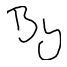

In [340]:
### USING 5% padding
# pad_inches: .05 => 71 dpi
# pad_inches: 0 => 68 dpi
pad_dpi = {"padding":.05, "dpi":71}
#pad_dpi = {"padding":0,   "dpi":80}

def prep_figure(dpi=71):
    plt.figure(figsize=(1, 1), dpi=dpi)
    plt.axis('off')
    plt.axis('square')
    
def draw_strokes(stroke_list, x_to_y=1, line_width=None, save_path=""):
    #plt.NullFormatter()
    if save_path:
        prep_figure(pad_dpi["dpi"])
    if line_width is None:
        linewidth=max(random.gauss(1,.5),.4)
    
    if x_to_y != 1:
        for stroke in stroke_list:
            stroke["x"] = [item * x_to_y for item in stroke["x"]]
    
    for stroke in stroke_list:
        plt.plot(stroke["x"], stroke["y"], linewidth=linewidth, color="black")

    y_min = min([min(x["y"]) for x in stroke_list])
    y_max = max([max(x["y"]) for x in stroke_list])
    x_min = min([min(x["x"]) for x in stroke_list])
    x_max = max([max(x["x"]) for x in stroke_list])

    plt.ylim([y_min, y_max])
    plt.xlim([x_min, x_max])
    print(y_min, y_max, x_min, x_max)
    if save_path:
        plt.savefig(save_path, pad_inches=pad_dpi["padding"], bbox_inches='tight')

def render_points_on_image(gts, img_path, strokes=None, save_path=None, x_to_y=None):
    gts = np.array(gts)
    
    if not x_to_y is None:
        gts[0] *= x_to_y
        
    
    x = gts[0]
    y = gts[1]
    start_points = gts[2]
    
    #prep_figure()
    if strokes:
        draw_strokes(normalize_stroke_list(strokes), x_to_y=x_to_y)
    elif img_path:
        img_path = Path(img_path)
        img = cv2.imread(img_path.as_posix(), cv2.IMREAD_GRAYSCALE)
        print(img.shape)
        print(img)
        img = img[::-1,:]
        plt.imshow(img, cmap="gray")
        
        # Rescale points
        factor = 2*pad_dpi["padding"]+1
        x = (x + 1) / 2 * 60/factor + pad_dpi["padding"]*60/2
        y = (y + 1) / 2 * 60/factor + pad_dpi["padding"]*60/2

    x_middle_strokes = x[np.where(start_points==0)]
    y_middle_strokes = y[np.where(start_points==0)]
    x_start_strokes = x[np.where(start_points==1)]
    y_start_strokes = y[np.where(start_points==1)]

    plt.scatter(x_middle_strokes,y_middle_strokes, s=4)
    plt.scatter(x_start_strokes,y_start_strokes, s=4)
    plt.show()
    if save_path:
        plt.savefig(save_path)


def create_dataset(max_strokes=3, square=True, instances=50, output_folder='.', xml_folder="../prepare_online_data/line-level-xml", json_path="../prepare_online_data/online_augmentation.json", img_folder="prepare_online_data/lineImages"):
    # Loop through files
    # Find image paths
    # create dicitonary
    json_path = Path(json_path)
    xml_folder = Path(xml_folder)
    original_img_folder = Path(img_folder)
    output_folder = Path(output_folder)
    new_img_folder = Path(output_folder) / "images"
    
    new_img_folder.mkdir(exist_ok=True, parents=True)
    data_dict = json.load(json_path.open("r"))    
    
    output_dict = {"train":[], "test":[]}
    
    for item in data_dict:
        file_name = Path(item["image_path"]).name
        rel_path = Path(item["image_path"]).relative_to(original_img_folder).with_suffix(".xml")
        xml_path = xml_folder / rel_path
        gts, stroke_list, x_to_y = get_gts(xml_path, instances=instances, max_stroke_count=max_strokes)
        
        if item["dataset"] in ["test","val1","val2"]:
            dataset = "test"
        else:
            dataset = "train"
        
        img_path = (new_img_folder / file_name).as_posix()
        new_item = {"gt":[gt.tolist() for gt in gts], 
                    "full_img_path": item["image_path"], 
                    "xml_path": xml_path.as_posix(), 
                    "dataset": dataset, 
                    "stroke_list":stroke_list, 
                    "x_to_y":x_to_y,
                    "img_path":img_path}
        output_dict[dataset].append(new_item)
        
        # Create images
        ratio = 1 if square else x_to_y
        draw_strokes(normalize_stroke_list(stroke_list), ratio, save_path=img_path)
    
        
        break
    json.dump(output_dict["train"], (output_folder / "train_online_coords.json").open("w"))
    json.dump(output_dict["test"], (output_folder / "test_online_coords.json").open("w"))

        
    return output_dict
    
output_dict = create_dataset(max_strokes=3, square=True, instances=30, output_folder="./3_stroke")


[1035, 1055, 1055, 1057, 1061, 1066, 1071, 1076, 1078, 1083, 1086, 1083, 1086]
[965, 960, 968, 994, 1023, 1055, 1094, 1124, 1149, 1162, 1172, 1165, 1156, 1150, 1155, 1164, 1185, 1208, 1228, 1249, 1268, 1279, 1286, 1281, 1269, 1252, 1228, 1199, 1170, 1143, 1121, 1107, 1096]
[1363, 1363, 1366, 1370, 1371, 1380, 1387, 1399, 1419, 1442, 1467, 1493, 1510, 1522, 1529, 1537, 1544, 1549, 1551, 1550, 1542, 1528, 1517, 1498, 1471, 1438, 1405, 1371, 1343, 1322, 1314, 1310, 1312, 1314, 1317, 1330, 1348]
-1.0 1.0 -1.05149749483909 1.05149749483909


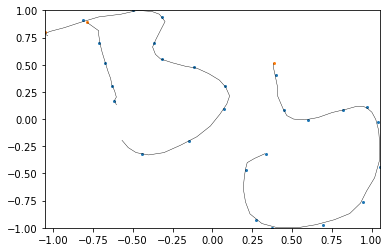

In [341]:
## Render points on strokes
instance = output_dict['train'][0]
render_points_on_image(instance['gt'], img_path=instance['img_path'], strokes=instance["stroke_list"], x_to_y=instance["x_to_y"])

(60, 60)
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


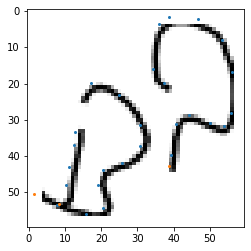

In [342]:
## Render points on image

render_points_on_image(instance['gt'], img_path=instance['img_path'])

In [83]:
x = np.array(instance['gt'])
[len(m) for m in x]

[50, 50, 50, 50, 50]

In [86]:
idx = np.where(x[2]==1)
x[1][idx]

array([0.88908817, 0.77899161, 0.47210899])

In [105]:
normalize_stroke_list(instance["stroke_list"])

[1035, 1055, 1055, 1057, 1061, 1066, 1071, 1076, 1078, 1083, 1086, 1083, 1086]
[965, 960, 968, 994, 1023, 1055, 1094, 1124, 1149, 1162, 1172, 1165, 1156, 1150, 1155, 1164, 1185, 1208, 1228, 1249, 1268, 1279, 1286, 1281, 1269, 1252, 1228, 1199, 1170, 1143, 1121, 1107, 1096]
[1363, 1363, 1366, 1370, 1371, 1380, 1387, 1399, 1419, 1442, 1467, 1493, 1510, 1522, 1529, 1537, 1544, 1549, 1551, 1550, 1542, 1528, 1517, 1498, 1471, 1438, 1405, 1371, 1343, 1322, 1314, 1310, 1312, 1314, 1317, 1330, 1348]


[{'x': [-0.7461928934010152,
   -0.6785109983079527,
   -0.6785109983079527,
   -0.6717428087986463,
   -0.6582064297800339,
   -0.6412859560067682,
   -0.6243654822335025,
   -0.607445008460237,
   -0.6006768189509306,
   -0.583756345177665,
   -0.5736040609137056,
   -0.583756345177665,
   -0.5736040609137056],
  'y': [0.8865248226950355,
   0.8120567375886525,
   0.7730496453900708,
   0.698581560283688,
   0.6134751773049645,
   0.5283687943262412,
   0.44326241134751765,
   0.37234042553191493,
   0.3156028368794326,
   0.25886524822695045,
   0.2021276595744681,
   0.17375886524822692,
   0.13120567375886516]},
 {'x': [-0.9830795262267343,
   -1.0,
   -0.9729272419627749,
   -0.8849407783417935,
   -0.7868020304568528,
   -0.6785109983079527,
   -0.5465313028764806,
   -0.44500846023688667,
   -0.36040609137055835,
   -0.3164128595600677,
   -0.2825719120135364,
   -0.3062605752961083,
   -0.33671742808798644,
   -0.3570219966159053,
   -0.3401015228426396,
   -0.3096446700507614

In [41]:
np.where(x[2])

(array([ 0,  8, 27]),)

In [48]:
x[1][x[2]]

TypeError: list indices must be integers or slices, not list

list

In [264]:
normalize(np.array(range(0,9)))

/home/taylor/anaconda3/envs/hw2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

101.33333333333334